## <center><h1>Narla_Nikhil_Final_Project</h1></center>

Name: Nikhil Narla 
<br>
Github Username: nikhilnarla
<br>
USC ID: 8815-9215-80

#### Import Packages

In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import splitfolders
import shutil
from tensorflow.keras.preprocessing.image import img_to_array
import statistics
import numpy as np
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score
import warnings
warnings.filterwarnings('ignore')

# Data Exploration and Pre-processing

In [2]:
# # !pip install opencv-python
# !pip install split-folders
gpus = tf.config.experimental.list_physical_devices('GPU')

#### Splitting the data into three sets, Train -70%, Validation-15%, Test - 15%

In [3]:
dirpath = '../Data/Sport Images/output'
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)

splitfolders.ratio("../Data/Sport Images", output="../Data/Sport Images/output",
    seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False) # default values

Copying files: 3280 files [00:01, 2668.33 files/s]


#### Resizing the images to a standard size to make sure all the images are of the same size

In [4]:
dirs = ['../Data/Sport Images/output/train','../Data/Sport Images/output/val','../Data/Sport Images/output/test']

desired_size = (256, 256)
for dir_path in dirs:
    for subdir in os.listdir(dir_path):
        subdir_path = os.path.join(dir_path, subdir)

        print(subdir_path)
        for filename in os.listdir(subdir_path):
            if filename.endswith('.gif'):
                continue
            img = cv2.imread(os.path.join(subdir_path, filename))

            
            resized_img = cv2.resize(img, desired_size)

            
            cv2.imwrite(os.path.join(subdir_path, filename), resized_img)


libpng warning: iCCP: known incorrect sRGB profile


../Data/Sport Images/output/train/baseball
../Data/Sport Images/output/train/basketball


libpng warning: iCCP: known incorrect sRGB profile


../Data/Sport Images/output/train/volleyball


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


../Data/Sport Images/output/train/fencing


libpng warning: iCCP: known incorrect sRGB profile


../Data/Sport Images/output/train/tennis


libpng warning: iCCP: known incorrect sRGB profile


../Data/Sport Images/output/val/baseball
../Data/Sport Images/output/val/basketball
../Data/Sport Images/output/val/volleyball
../Data/Sport Images/output/val/fencing
../Data/Sport Images/output/val/tennis
../Data/Sport Images/output/test/baseball
../Data/Sport Images/output/test/basketball
../Data/Sport Images/output/test/volleyball
../Data/Sport Images/output/test/fencing
../Data/Sport Images/output/test/tennis


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


#### Creating the keras datasets

In [5]:
image_size = (256, 256)
batch = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Sport Images/output/train',
    labels='inferred',
    batch_size=batch

)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Sport Images/output/val',
    labels='inferred',
    batch_size=batch

)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Sport Images/output/test',
    labels='inferred', 
    batch_size=batch,
    shuffle=False
)


Found 2292 files belonging to 5 classes.
Metal device set to: Apple M1 Pro
Found 490 files belonging to 5 classes.
Found 497 files belonging to 5 classes.


#### Data Augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))
])


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))



# Transfer learning- ResNet50

#### Using the Resnet50 model as base and building the custom ResNetModel 

In [7]:
input_shape = (256, 256, 3)
batch_size = batch
num_classes = 5


resnet_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

for layer in resnet_model.layers:
    layer.trainable = False

x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)

resnet50model = Model(inputs=resnet_model.input, outputs=predictions)

resnet50model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience = 10, restore_best_weights=True)


history_resnet = resnet50model.fit(train_ds, epochs=50, batch_size=batch, validation_data=val_ds, callbacks=[early_stop])


Epoch 1/50


2023-05-08 17:49:04.844721: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


72/72 [==============================] - 31s 402ms/step - loss: 0.8386 - accuracy: 0.7177 - val_loss: 0.6631 - val_accuracy: 0.8327
Epoch 2/50
72/72 [==============================] - 28s 384ms/step - loss: 0.5394 - accuracy: 0.8050 - val_loss: 0.5683 - val_accuracy: 0.8347
Epoch 3/50
72/72 [==============================] - 27s 378ms/step - loss: 0.5027 - accuracy: 0.8150 - val_loss: 0.3472 - val_accuracy: 0.8857
Epoch 4/50
72/72 [==============================] - 27s 376ms/step - loss: 0.4287 - accuracy: 0.8469 - val_loss: 0.3855 - val_accuracy: 0.8837
Epoch 5/50
72/72 [==============================] - 27s 376ms/step - loss: 0.3895 - accuracy: 0.8634 - val_loss: 0.3594 - val_accuracy: 0.8857
Epoch 6/50
72/72 [==============================] - 27s 377ms/step - loss: 0.3960 - accuracy: 0.8613 - val_loss: 0.3515 - val_accuracy: 0.8673
Epoch 7/50
72/72 [==============================] - 27s 379ms/step - loss: 0.4034 - accuracy: 0.8503 - val_loss: 0.3311 - val_accuracy: 0.8878
Epoch 8/50

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Sport Images/output/train',
    labels='inferred',
    batch_size=batch,
    shuffle=False
)


Found 2292 files belonging to 5 classes.


#### Loss vs Epochs Graph

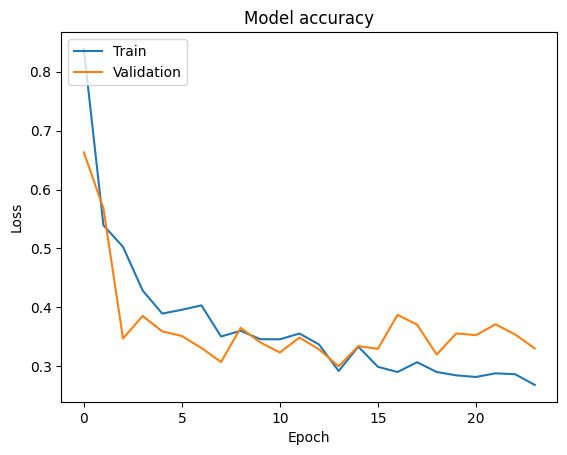

In [9]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



#### Accuracy, F1-score, confusion matrix on train and test data sets

In [10]:
# Evaluate on training set
train_pred = resnet50model.predict(train_ds)
train_pred_labels = np.argmax(train_pred, axis=1)
train_true_labels = np.concatenate([y for x, y in train_ds], axis=0)

# Evaluate on test set
test_pred = resnet50model.predict(test_ds)
test_pred_labels = np.argmax(test_pred, axis=1)
test_true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate evaluation metrics
train_cm = confusion_matrix(train_true_labels, train_pred_labels)
train_cr = classification_report(train_true_labels, train_pred_labels)
train_acc = accuracy_score(train_true_labels, train_pred_labels)
train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')

test_cm = confusion_matrix(test_true_labels, test_pred_labels)
test_cr = classification_report(test_true_labels, test_pred_labels)
test_acc = accuracy_score(test_true_labels, test_pred_labels)
test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')

print("\nEvaluation Metrics on Training Set:")
print("Confusion Matrix:\n", train_cm)
print("Classification Report:\n", train_cr)
print("Accuracy: ", train_acc)
print("F1 Score: ", train_f1)

print("\nEvaluation Metrics on Test Set:")
print("Confusion Matrix:\n", test_cm)
print("Classification Report:\n", test_cr)
print("Accuracy: ", test_acc)
print("F1 Score: ", test_f1)


16/16 [==============================] - 3s 186ms/step

Evaluation Metrics on Training Set:
Confusion Matrix:
 [[483   5  11   5   9]
 [  3 326   5   1   9]
 [  2   1 427   5   8]
 [  5   2   4 483   6]
 [  2  10   9   4 467]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       513
           1       0.95      0.95      0.95       344
           2       0.94      0.96      0.95       443
           3       0.97      0.97      0.97       500
           4       0.94      0.95      0.94       492

    accuracy                           0.95      2292
   macro avg       0.95      0.95      0.95      2292
weighted avg       0.95      0.95      0.95      2292

Accuracy:  0.9537521815008726
F1 Score:  0.9538043670116892

Evaluation Metrics on Test Set:
Confusion Matrix:
 [[ 99   2   3   2   5]
 [  0  67   3   1   4]
 [  1   2  89   4   0]
 [  3   2   1  98   4]
 [  1   0   1   5 100]]
Classification Report:
         

# Video Classification Model - ResNet50

#### Improving the model for deep learning by combining test and validation data and using epochs from the previous training to prevent overfitting

In [11]:
num_epochs = len(history_resnet.history['loss'])
print("Model ran for {} epochs".format(num_epochs))

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Sport Images/output/test',
    labels='inferred', 
    batch_size=batch,
    shuffle=True
)

test_val_ds = val_ds.concatenate(test_ds)
test_val_ds = test_val_ds.map(lambda x, y: (data_augmentation(x), y))

resnet50model.fit(test_val_ds, epochs=num_epochs, batch_size=batch)


Model ran for 24 epochs
Found 497 files belonging to 5 classes.
Epoch 1/24
32/32 [==============================] - 12s 364ms/step - loss: 0.6053 - accuracy: 0.8034
Epoch 2/24
32/32 [==============================] - 11s 338ms/step - loss: 0.4388 - accuracy: 0.8460
Epoch 3/24
32/32 [==============================] - 11s 333ms/step - loss: 0.3781 - accuracy: 0.8632
Epoch 4/24
32/32 [==============================] - 11s 336ms/step - loss: 0.3676 - accuracy: 0.8561
Epoch 5/24
32/32 [==============================] - 11s 332ms/step - loss: 0.3995 - accuracy: 0.8622
Epoch 6/24
32/32 [==============================] - 11s 335ms/step - loss: 0.3261 - accuracy: 0.8815
Epoch 7/24
32/32 [==============================] - 11s 341ms/step - loss: 0.3148 - accuracy: 0.8906
Epoch 8/24
32/32 [==============================] - 11s 335ms/step - loss: 0.3078 - accuracy: 0.8865
Epoch 9/24
32/32 [==============================] - 11s 330ms/step - loss: 0.2995 - accuracy: 0.8875
Epoch 10/24
32/32 [========

# Transfer learning- EfficientNet

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Sport Images/output/train',
    labels='inferred',
    batch_size=batch

)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Found 2292 files belonging to 5 classes.


#### Using the EfficientNet model as base and building the custom EfficientNet Model 

In [13]:
input_shape = (256, 256, 3)
batch_size = batch
num_classes = 5


EfficientNetB0_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

for layer in EfficientNetB0_model.layers:
    layer.trainable = False

x = EfficientNetB0_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetmodel = Model(inputs=EfficientNetB0_model.input, outputs=predictions)


EfficientNetmodel.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience = 10, restore_best_weights=True)


history_EfficientNetmodel = EfficientNetmodel.fit(train_ds, epochs=50, batch_size=batch, validation_data=val_ds, callbacks=[early_stop])


Epoch 1/50
72/72 [==============================] - 30s 362ms/step - loss: 0.6629 - accuracy: 0.7980 - val_loss: 0.2310 - val_accuracy: 0.9245
Epoch 2/50
72/72 [==============================] - 23s 312ms/step - loss: 0.3908 - accuracy: 0.8739 - val_loss: 0.2032 - val_accuracy: 0.9388
Epoch 3/50
72/72 [==============================] - 23s 313ms/step - loss: 0.3457 - accuracy: 0.8822 - val_loss: 0.1963 - val_accuracy: 0.9367
Epoch 4/50
72/72 [==============================] - 22s 304ms/step - loss: 0.3075 - accuracy: 0.8940 - val_loss: 0.1751 - val_accuracy: 0.9327
Epoch 5/50
72/72 [==============================] - 22s 308ms/step - loss: 0.3039 - accuracy: 0.8940 - val_loss: 0.1739 - val_accuracy: 0.9327
Epoch 6/50
72/72 [==============================] - 22s 306ms/step - loss: 0.2867 - accuracy: 0.8935 - val_loss: 0.1666 - val_accuracy: 0.9429
Epoch 7/50
72/72 [==============================] - 22s 305ms/step - loss: 0.2542 - accuracy: 0.9119 - val_loss: 0.1889 - val_accuracy: 0.9347

#### Loss vs Epochs Graph

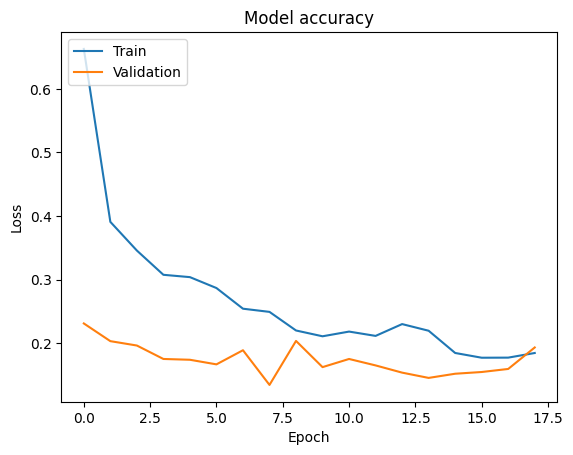

In [14]:
plt.plot(history_EfficientNetmodel.history['loss'])
plt.plot(history_EfficientNetmodel.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Sport Images/output/train',
    labels='inferred',
    batch_size=batch,
    shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Sport Images/output/test',
    labels='inferred', 
    batch_size=batch,
    shuffle=False
)

Found 2292 files belonging to 5 classes.
Found 497 files belonging to 5 classes.


#### Accuracy, F1-score, confusion matrix on train and test data sets

In [16]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score

# Evaluate on training set
train_pred = EfficientNetmodel.predict(train_ds)
train_pred_labels = np.argmax(train_pred, axis=1)
train_true_labels = np.concatenate([y for x, y in train_ds], axis=0)

# Evaluate on test set
test_pred = EfficientNetmodel.predict(test_ds)
test_pred_labels = np.argmax(test_pred, axis=1)
test_true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate evaluation metrics
train_cm = confusion_matrix(train_true_labels, train_pred_labels)
train_cr = classification_report(train_true_labels, train_pred_labels)
train_acc = accuracy_score(train_true_labels, train_pred_labels)
train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')

test_cm = confusion_matrix(test_true_labels, test_pred_labels)
test_cr = classification_report(test_true_labels, test_pred_labels)
test_acc = accuracy_score(test_true_labels, test_pred_labels)
test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')

print("\nEvaluation Metrics on Training Set:")
print("Confusion Matrix:\n", train_cm)
print("Classification Report:\n", train_cr)
print("Accuracy: ", train_acc)
print("F1 Score: ", train_f1)

print("\nEvaluation Metrics on Test Set:")
print("Confusion Matrix:\n", test_cm)
print("Classification Report:\n", test_cr)
print("Accuracy: ", test_acc)
print("F1 Score: ", test_f1)


16/16 [==============================] - 4s 241ms/step

Evaluation Metrics on Training Set:
Confusion Matrix:
 [[509   0   0   2   2]
 [  2 333   2   1   6]
 [  3   2 433   4   1]
 [  1   1   0 493   5]
 [  1   9   1   1 480]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       513
           1       0.97      0.97      0.97       344
           2       0.99      0.98      0.99       443
           3       0.98      0.99      0.99       500
           4       0.97      0.98      0.97       492

    accuracy                           0.98      2292
   macro avg       0.98      0.98      0.98      2292
weighted avg       0.98      0.98      0.98      2292

Accuracy:  0.9808027923211169
F1 Score:  0.9808092601004027

Evaluation Metrics on Test Set:
Confusion Matrix:
 [[107   1   2   1   0]
 [  0  74   0   0   1]
 [  2   0  92   1   1]
 [  5   0   0 101   2]
 [  0   3   1   2 101]]
Classification Report:
         

# Video Classification Model - EfficientNet

#### Improving the model for deep learning by combining test and validation data and using epochs from the previous training to prevent overfitting

In [17]:
num_epochs = len(history_EfficientNetmodel.history['loss'])
print("Model ran for {} epochs".format(num_epochs))


EfficientNetmodel.fit(test_val_ds, epochs=num_epochs, batch_size=batch)


Model ran for 18 epochs
Epoch 1/18
32/32 [==============================] - 13s 381ms/step - loss: 0.4152 - accuracy: 0.8612
Epoch 2/18
32/32 [==============================] - 10s 292ms/step - loss: 0.3448 - accuracy: 0.8815
Epoch 3/18
32/32 [==============================] - 9s 287ms/step - loss: 0.2471 - accuracy: 0.9108
Epoch 4/18
32/32 [==============================] - 9s 293ms/step - loss: 0.2544 - accuracy: 0.9149
Epoch 5/18
32/32 [==============================] - 9s 289ms/step - loss: 0.2398 - accuracy: 0.9220
Epoch 6/18
32/32 [==============================] - 9s 291ms/step - loss: 0.2482 - accuracy: 0.9220
Epoch 7/18
32/32 [==============================] - 9s 293ms/step - loss: 0.1914 - accuracy: 0.9291
Epoch 8/18
32/32 [==============================] - 9s 277ms/step - loss: 0.2201 - accuracy: 0.9098
Epoch 9/18
32/32 [==============================] - 9s 274ms/step - loss: 0.2277 - accuracy: 0.9149
Epoch 10/18
32/32 [==============================] - 9s 288ms/step - loss:

# Transfer learning- VGG16

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Sport Images/output/train',
    labels='inferred',
    batch_size=batch

)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Found 2292 files belonging to 5 classes.


#### Using the VGG16 model as base and building the custom VGG16 Model 

In [19]:
input_shape = (256, 256, 3)
batch_size = 5
num_classes = 5


VGG16_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

for layer in VGG16_model.layers:
    layer.trainable = False


x = VGG16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)

VGGmodel = Model(inputs=VGG16_model.input, outputs=predictions)


VGGmodel.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience = 10, restore_best_weights=True)


history_VGGmodel = VGGmodel.fit(train_ds, epochs=50, batch_size=batch, validation_data=val_ds, callbacks=[early_stop])


Epoch 1/50
72/72 [==============================] - 42s 558ms/step - loss: 0.9516 - accuracy: 0.6789 - val_loss: 0.6525 - val_accuracy: 0.8163
Epoch 2/50
72/72 [==============================] - 40s 559ms/step - loss: 0.6149 - accuracy: 0.7696 - val_loss: 0.7701 - val_accuracy: 0.7714
Epoch 3/50
72/72 [==============================] - 40s 555ms/step - loss: 0.5593 - accuracy: 0.8058 - val_loss: 0.6568 - val_accuracy: 0.8000
Epoch 4/50
72/72 [==============================] - 40s 552ms/step - loss: 0.5213 - accuracy: 0.8089 - val_loss: 0.6146 - val_accuracy: 0.8265
Epoch 5/50
72/72 [==============================] - 40s 555ms/step - loss: 0.5075 - accuracy: 0.8168 - val_loss: 0.6415 - val_accuracy: 0.7959
Epoch 6/50
72/72 [==============================] - 40s 553ms/step - loss: 0.4677 - accuracy: 0.8268 - val_loss: 0.5422 - val_accuracy: 0.8347
Epoch 7/50
72/72 [==============================] - 40s 552ms/step - loss: 0.4836 - accuracy: 0.8364 - val_loss: 0.7682 - val_accuracy: 0.7980

#### Loss vs Epochs Graph

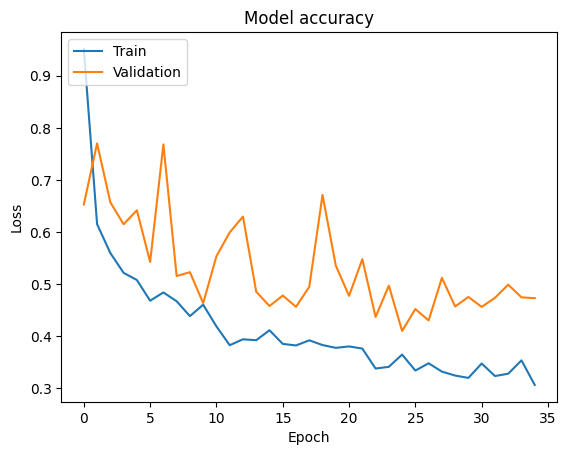

In [20]:
plt.plot(history_VGGmodel.history['loss'])
plt.plot(history_VGGmodel.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Sport Images/output/train',
    labels='inferred',
    batch_size=batch,
    shuffle=False
)


Found 2292 files belonging to 5 classes.


#### Accuracy, F1-score, confusion matrix on train and test data sets

In [22]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score

# Evaluate on training set
train_pred = VGGmodel.predict(train_ds)
train_pred_labels = np.argmax(train_pred, axis=1)
train_true_labels = np.concatenate([y for x, y in train_ds], axis=0)

# Evaluate on test set
test_pred = VGGmodel.predict(test_ds)
test_pred_labels = np.argmax(test_pred, axis=1)
test_true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate evaluation metrics
train_cm = confusion_matrix(train_true_labels, train_pred_labels)
train_cr = classification_report(train_true_labels, train_pred_labels)
train_acc = accuracy_score(train_true_labels, train_pred_labels)
train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')

test_cm = confusion_matrix(test_true_labels, test_pred_labels)
test_cr = classification_report(test_true_labels, test_pred_labels)
test_acc = accuracy_score(test_true_labels, test_pred_labels)
test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')

print("\nEvaluation Metrics on Training Set:")
print("Confusion Matrix:\n", train_cm)
print("Classification Report:\n", train_cr)
print("Accuracy: ", train_acc)
print("F1 Score: ", train_f1)

print("\nEvaluation Metrics on Test Set:")
print("Confusion Matrix:\n", test_cm)
print("Classification Report:\n", test_cr)
print("Accuracy: ", test_acc)
print("F1 Score: ", test_f1)


16/16 [==============================] - 5s 333ms/step

Evaluation Metrics on Training Set:
Confusion Matrix:
 [[492   4   4   9   4]
 [  7 302   3   3  29]
 [  9   3 412   9  10]
 [ 11   1   1 481   6]
 [ 12   2  11   6 461]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       513
           1       0.97      0.88      0.92       344
           2       0.96      0.93      0.94       443
           3       0.95      0.96      0.95       500
           4       0.90      0.94      0.92       492

    accuracy                           0.94      2292
   macro avg       0.94      0.93      0.94      2292
weighted avg       0.94      0.94      0.94      2292

Accuracy:  0.93717277486911
F1 Score:  0.9370884824717526

Evaluation Metrics on Test Set:
Confusion Matrix:
 [[105   0   1   4   1]
 [  4  62   0   1   8]
 [  2   0  85   5   4]
 [ 10   0   1  96   1]
 [  2   0   5   4  96]]
Classification Report:
           

# Video Classification Model - VGGModel

#### Improving the model for deep learning by combining test and validation data and using epochs from the previous training to prevent overfitting

In [23]:
num_epochs = len(history_VGGmodel.history['loss'])
print("Model ran for {} epochs".format(num_epochs))


VGGmodel.fit(test_val_ds, epochs=num_epochs, batch_size=batch)


Model ran for 35 epochs
Epoch 1/35
32/32 [==============================] - 16s 500ms/step - loss: 0.5758 - accuracy: 0.8126
Epoch 2/35
32/32 [==============================] - 15s 477ms/step - loss: 0.4780 - accuracy: 0.8349
Epoch 3/35
32/32 [==============================] - 15s 473ms/step - loss: 0.5342 - accuracy: 0.8116
Epoch 4/35
32/32 [==============================] - 15s 479ms/step - loss: 0.4375 - accuracy: 0.8288
Epoch 5/35
32/32 [==============================] - 16s 495ms/step - loss: 0.3960 - accuracy: 0.8470
Epoch 6/35
32/32 [==============================] - 16s 486ms/step - loss: 0.4652 - accuracy: 0.8369
Epoch 7/35
32/32 [==============================] - 15s 477ms/step - loss: 0.3720 - accuracy: 0.8622
Epoch 8/35
32/32 [==============================] - 16s 494ms/step - loss: 0.4010 - accuracy: 0.8460
Epoch 9/35
32/32 [==============================] - 16s 485ms/step - loss: 0.3908 - accuracy: 0.8582
Epoch 10/35
32/32 [==============================] - 16s 487ms/step

# Video Prediction for all three models

#### Extracting the frames from the videos and using the above three trained models for predicting the majority class for each video

In [24]:
from tensorflow.keras.preprocessing.image import img_to_array
import statistics

class_names = {'BaseballPitch':0, 'Basketball':1, 'Fencing':2, 'TennisSwing':3, 'VolleyballSpiking':4}
true_labels = []
predictions1 = []
predictions2 = []
predictions3 = []
avg_predictions1 = []
avg_predictions2 = []
avg_predictions3 = []
num_predictions = 0
video_path = '../Data/Sport Videos'

for dir_path in os.listdir(video_path):
    if not os.path.basename(dir_path).startswith('.'):
        sub_path = os.path.join(video_path,dir_path)

        for filename in os.listdir(sub_path):
            true_label = class_names[dir_path]
            true_labels.append(true_label) 
            video = cv2.VideoCapture(os.path.join(sub_path,filename))
            num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            probabilities1 = []
            probabilities2 = []
            probabilities3 = []
            stride = max(num_frames // 100, 1)
            count = 0
            for frame_num in range(0, num_frames, strides):
                if count >100:
                    break
                video.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
                ret, frame = video.read()
                if not ret:
                    continue
                frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (256, 256))
                frame = img_to_array(frame)
                frame = np.expand_dims(frame, axis=0)
                
                prediction1 = resnet50model.predict(frame)
                prediction2 = EfficientNetmodel.predict(frame)
                prediction3 = VGGmodel.predict(frame)
                probabilities1.append(prediction1)
                probabilities2.append(prediction2)
                probabilities3.append(prediction3)
                count += 1

            avg_prediction1 = np.mean(probabilities1, axis=0) 
            avg_predictions1.append(avg_prediction1) 
        
            avg_prediction2 = np.mean(probabilities2, axis=0) 
            avg_predictions2.append(avg_prediction2) 
            
            avg_prediction3 = np.mean(probabilities3, axis=0) 
            avg_predictions3.append(avg_prediction3) 

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 12ms/step


#### Accuracies, F-1 Scores, Confusion MAtrix for all the three models on the video dataset

In [25]:
# Convert the true labels and predictions to numpy arrays
true_labels = np.array(true_labels)
predictions1 = np.argmax(np.concatenate(avg_predictions1, axis=0), axis=1)

# Calculate the confusion matrix, precision, recall, accuracy, and F1 score
conf_mat = confusion_matrix(true_labels, predictions1)
cr = classification_report(true_labels, predictions1)
acc = accuracy_score(true_labels, predictions1)
f1 = f1_score(true_labels, predictions1, average='weighted')
print("\nModel : ResNet50")
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", cr)
print("Accuracy: ", acc)
print("F1 Score: ", f1)



predictions2 = np.argmax(np.concatenate(avg_predictions2, axis=0), axis=1)

# Calculate the confusion matrix, precision, recall, accuracy, and F1 score
conf_mat = confusion_matrix(true_labels, predictions2)
cr = classification_report(true_labels, predictions2)
acc = accuracy_score(true_labels, predictions2)
f1 = f1_score(true_labels, predictions2, average='weighted')
print("\nModel : EfficeintNet")
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", cr)
print("Accuracy: ", acc)
print("F1 Score: ", f1)


predictions3 = np.argmax(np.concatenate(avg_predictions3, axis=0), axis=1)

# Calculate the confusion matrix, precision, recall, accuracy, and F1 score
conf_mat = confusion_matrix(true_labels, predictions3)
cr = classification_report(true_labels, predictions3)
acc = accuracy_score(true_labels, predictions3)
f1 = f1_score(true_labels, predictions3, average='weighted')
print("\nModel : VGG16")
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", cr)
print("Accuracy: ", acc)
print("F1 Score: ", f1)


Model : ResNet50
Confusion Matrix:
 [[140   0   2   6   2]
 [  6   0  39  73  19]
 [ 15   0  95   1   0]
 [ 12   0   7 148   0]
 [  3   0  85   0  28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86       150
           1       0.00      0.00      0.00       137
           2       0.42      0.86      0.56       111
           3       0.65      0.89      0.75       167
           4       0.57      0.24      0.34       116

    accuracy                           0.60       681
   macro avg       0.49      0.58      0.50       681
weighted avg       0.50      0.60      0.52       681

Accuracy:  0.6035242290748899
F1 Score:  0.5221156328574408

Model : EfficeintNet
Confusion Matrix:
 [[137   0   6   7   0]
 [  3   1  42  71  20]
 [  5   0 105   1   0]
 [  3   0  11 153   0]
 [  0   1  61   4  50]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91     